# Generation of local synthetic genomic datasets

This notebook contains the some of the code to process the generated datasets and draw all the plots for the analysis presented in the manuscript.

In [2]:
import pandas as pd 
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import numpy as np
import pandas as pd
import glob
import os
import warnings
import pyfaidx
warnings.filterwarnings("ignore", "is_categorical_dt")
warnings.filterwarnings("ignore", "use_inf_as_na")                        

In [3]:
! pip install plotnine --quiet
! pip install tqdm --quiet
! pip install celluloid --quiet
from plotnine import *

## Auxiliar functions

Some functions that will be repeatidely used across the notebook.

In [4]:
def load_archive_checkpoints(
    list_of_evolution_directories,
    seeds=(0, 5),
    tags: list = None,
    just_last_generation=False,
):
    archives_full = []
    for j, single_evol in enumerate(list_of_evolution_directories):
        print("Reading directory: ", single_evol)
        df = pd.DataFrame()
        files = [
            f
            for i in range(seeds[0], seeds[1])
            for f in glob.glob(single_evol + f"/*seed_{i}_archive_logger.csv.gz")
        ]
        for file in files:
            _df = pd.read_csv(file)
            _df.Run_id = single_evol.split("/")[-1]
            df = pd.concat([df, _df])

        if tags:
            df["Tag"] = tags[j]

        archives_full.append(df)
    archives_full = pd.concat(archives_full, ignore_index=True)
    archives_full = archives_full.sort_values(by=["Run_id", "Seed", "Generation"])
    archives_full["Time(min)"] = archives_full.Execution_time / 60
    archives_full["Run_id"] = archives_full.Run_id.str.replace(
        "increase_archive_diversity", "IAD"
    )

    if just_last_generation:
        return (
            archives_full.groupby(["Run_id", "Seq_id", "Seed"])
            .apply(lambda x: x.loc[x.Generation.idxmax()])
            .reset_index(drop=True)
        )

    return archives_full

In [5]:
def load_datasets(evolutions: list, tags: list):
    full_datasets = []
    for j, single_evol in enumerate(evolutions):
        print("Reading directory: ", single_evol)

        df = pd.DataFrame()
        files = [f for i in range(30, 60) for f in glob.glob(single_evol + f"/*seed_{i}_dataset.csv.gz")]
        for file in files:
            _df = pd.read_csv(file)
            _df.Run_id = single_evol.split('/')[-1]
            df = pd.concat([df, _df])
        df['Tag'] = tags[j]

        full_datasets.append(df)
    df = pd.concat(full_datasets, ignore_index=True)

    df = df.sort_values(by=['Run_id', 'Seed'])
    df['Run_id'] = df.Run_id.str.replace('increase_archive_diversity', 'IAD')

    return df

## Some general plots

### Lineplots through evolution

In [6]:
import math
sns.set_style("ticks")

def lineplots_through_time(
    _df: pd.DataFrame,
    y: str = "Archive_quality",
    hue: str = "Run_id",
    ylabel: str = None,
    ylim: tuple = None,
    draw_legend_outside: bool = False,
    per_seed: bool = True,
    time_interval: int = 10,
    figsize = (10, 3),
    color_pallette: list = None,
    outfile: str = None
):

    df = _df.copy()
    if color_pallette is None:
        n_colors = df["Run_id"].nunique()
        if len(sns.color_palette("deep")) < n_colors:
            colors = None
        else:
            colors = sns.color_palette("deep")[:n_colors]
    else:
        colors = color_pallette    
    
    if per_seed:
        assert "Time(min)" in df.columns, "df must have a Time(min) column"

        seed_values = df.Seed.unique()
        n_seeds = len(seed_values)
        n_cols = math.ceil(math.sqrt(n_seeds))
        n_rows = (n_seeds - 1) // n_cols + 1

        fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(figsize[0], figsize[1] * n_rows))
        axes = axes.flatten()

        for i, seed in enumerate(seed_values):
            seed_df = df[df["Seed"] == seed]
            n_colors = seed_df["Run_id"].nunique()
    
            sns.lineplot(
                data=seed_df,
                x="Time(min)",
                y=y,
                hue="Run_id",
                alpha=0.8,
                linewidth=0.1,
                palette=colors,
                ax=axes[i],
                legend=True,
            )
            sns.scatterplot(
                data=seed_df,
                x="Time(min)",
                y=y,
                hue="Run_id",
                legend=False,
                alpha=0.8,
                s=5,
                palette=colors,
                ax=axes[i],
            )
            axes[i].set_title(f"Seed {seed}")
            axes[i].set_xlabel("Time (min)")
            axes[i].set_ylabel(f'{y.replace("_", " ")}')

        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes[j])

        handles, labels = axes[0].get_legend_handles_labels()
        for line in handles:
            line.set_linewidth(2.0)
        fig.legend(handles, labels, bbox_to_anchor=(1.25, 1))
        for ax in axes:
            try:
                ax.get_legend().remove()
            except AttributeError:
                pass

        fig.subplots_adjust(hspace=0.95, wspace=0.1)
        plt.tight_layout()
        plt.show()
        plt.close()

    else:
                
        df["Time_intervals"] = pd.cut(
            df["Time(min)"] * 60,
            bins=np.arange(
                0, (df["Time(min)"].max() * 60) + time_interval, time_interval
            ),
        )
        df['Time(min)'] = df['Time_intervals'].apply(lambda interval: (interval.left + interval.right) / 2)
        df['Time(min)'] = df['Time(min)'].astype(float) / 60
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        sns.lineplot(x="Time(min)", y=y,
             hue=hue, errorbar='sd', 
             data=df, markers=True, ax=ax, palette=colors)

        
        if ylabel is None:
            ylabel = y.replace("_", " ")
        ax.set_ylabel(ylabel)
        ax.get_legend().set_title(None)
        
        if draw_legend_outside:
            plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=7)
        
        if ylim is not None:
            ax.set_ylim(ylim)
            
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    plt.close()

In [7]:
def lineplots(df: pd.DataFrame, x: str = 'Generation', y: str = 'Archive_size', metric: str = 'mean', color_pallette: list = None, outfile: str = None):
    """
    Draw lineplots of the evolution of the archive through a discrete variable, by default the generation number.
    
    Args:
        df (pd.DataFrame): Dataframe with the data to plot.
        x (str, optional): Column to plot in X axis. Defaults to 'Generation'.
        y (str, optional): Column to plot in Y axis. Defaults to 'Archive_size'.
        metric (str, optional): Metric to aggregate the y column across seeds. Defaults to 'mean'.
    """
    assert 'Time' not in x, "To plot through time, use 'lineplots_through_time' function"
    
    if color_pallette is None:
        n_colors = df["Run_id"].nunique()
        if len(sns.color_palette("deep")) < n_colors:
            colors = None
        else:
            colors = sns.color_palette("deep")[:n_colors]
    else:
        colors = color_pallette    
        
    groupby_cols = ['Run_id', x]
    archive_stats = df.groupby(groupby_cols)[y].agg([metric, 'std']).reset_index()
    
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(data=df, x=x, y=y, errorbar='sd', hue='Run_id', alpha=0.8, linewidth=0.5, palette=colors, ax=ax)
    sns.scatterplot(data=archive_stats, x=x, y=metric, hue='Run_id', legend=False, alpha=0.8, s=20, palette=colors, ax=ax)
    legend = plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))
    for line in legend.get_lines():
        line.set_linewidth(2.0)  
    plt.ylabel(f'{y.replace("_", " ")}')
    
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    plt.close()

In [8]:
def facet_lineplot(df, by, n_cols=1, outfile: str = None, **kwargs):
    g = sns.FacetGrid(df, col=by, col_wrap=n_cols, sharey=False, sharex=True, height=1.5)
    df["Time_intervals"] = pd.cut(
        df["Time(min)"] * 60,
        bins=np.arange(
            0, (df["Time(min)"].max() * 60) + kwargs['time_interval'], kwargs['time_interval']
        ),
    )
    df['Time(min)'] = df['Time_intervals'].apply(lambda interval: (interval.left + interval.right) / 2)
    df['Time(min)'] = df['Time(min)'].astype(float) / 60
    g.map_dataframe(
        sns.lineplot,
        data=df,
        x='Time(min)',
        hue='Tag',
        y='Value',
        errorbar='sd',
        palette=kwargs['color_pallette'],
    )
    g.set(xlim=(0, 10), ylim=(0, None))
    g.axes[0].set_ylim(0, 1)
    g.axes[1].set_ylim(0, 5000)
    g.axes[2].set_ylim(0, 1)
    g.set_titles("{col_name}", size=7)
    g.set_xticklabels(size=7)
    g.set_yticklabels(size=7)
    g.set_axis_labels("", "")
    plt.legend(loc='upper right', bbox_to_anchor=(2, 1.1), ncol=1, fontsize=7)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    plt.close()

### Performance boxplot

In [9]:
def draw_boxplot(
    df: pd.DataFrame,
    x: str,
    y: str,
    ylabel: str,
    xlabel: str = None,
    color_pallette: list = None,
    do_statistical_test: bool = True,
    title: str = None,
    xlim: tuple = None,
    ylim: tuple = None,
    figsize: tuple = (3, 3),
    include_xlabels: bool = True,
    x_label_rotation: int = 45,
    legend_outside: bool = False,
    outfile: str = None
):

    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
    ax = sns.stripplot(
        data=df,
        x=x,
        hue=x,
        y=y,
        palette=color_pallette,
        linewidth=0.25,
        edgecolor="black",
        color="grey",
        alpha=0.4,
        legend=False,
        dodge=False,
    )
    sns.boxplot(
        data=df,
        x=x,
        hue=x,
        y=y,
        boxprops=dict(alpha=0.9),
        palette=color_pallette,
        showfliers=False,
        legend=False,
        zorder=10,
        ax=ax
    )

    # Do test
    if do_statistical_test:

        pairs = [
            ("GGGP_BF", "RS_BF"),
            ("GGGP_IAD", "RS_IAD"),
            ("GGGP_BF", "GGGP_IAD"),
        ]
        p_vals = []
        
        for pair in pairs:
            grp1 = df[df.Run_id == pair[0]].Archive_quality
            grp2 = df[df.Run_id == pair[1]].Archive_quality

            _, p_val = stats.ttest_ind(grp1, grp2, equal_var=False)
            p_vals.append(p_val)

        # Apply Bonferroni correction
        num_tests = len(pairs)
        adj_p_vals = [p * num_tests for p in p_vals] 
        
        # Annotate
        ids = {"GGGP_BF": 0, "RS_BF": 1, "GGGP_IAD": 2, "RS_IAD": 3}
        to_add = 0
        for i, p in enumerate(pairs):
            x1, x2 = ids[p[0]], ids[p[1]]
            y, h, col = df.Archive_quality.max() + 0.005, 0.005, "k"

            plt.plot(
                [x1, x1, x2, x2],
                [y + to_add, y + h + to_add, y + h + to_add, y + to_add],
                lw=0.5,
                c=col,
            )
            pvalue = adj_p_vals[i]
            if pvalue > 0.0001:
                pvalue = str(round(pvalue, 4))
            else:
                pvalue = str(format(pvalue, ".2e"))
            plt.text((x1 + x2) * 0.5, y + h + to_add, f'p={pvalue}', ha="center", va="bottom", color=col, fontsize=6)
            to_add += 0.0075
        plt.ylim(0.8, 1.03)
        
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=8)
    else:
        ax.set_xlabel("")
    
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=8)
    
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
    
    if include_xlabels is False:
        ax.set_xticklabels([])
        ax.set_xticks([])
    else:
        ax.tick_params(axis='x', which='major', labelsize=8, rotation=x_label_rotation)
        #ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize': 9}, rotation=x_label_rotation)#, ha="right")
    
    if title:
        ax.set_title(title, fontsize=9)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if legend_outside:
        ax.legend(bbox_to_anchor=(1.1, 0.9), ncol=1, fontsize=8)
            
    # As FacetGrid
    # g = sns.catplot(
    #     data=df,
    #     x=x,
    #     hue=x,
    #     y=y,
    #     col="Fitness_function",
    #     col_wrap=2,
    #     kind="strip",
    #     palette="dark:grey",
    #     linewidth=0.25,
    #     edgecolor="black",
    #     alpha=0.4,
    #     dodge=False,
    #     height=2.75,
    #     aspect=0.8,
    # )
    # g.map_dataframe(
    #     sns.boxplot,
    #     data=df,
    #     x=x,
    #     hue=x,
    #     y=y,
    #     boxprops=dict(alpha=0.9),
    #     palette=color_pallette,
    #     showfliers=False,
    #     legend=False,
    #     zorder=10,
    # )

    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    plt.close()

In [10]:
def facet_boxplot(df, by, **kwargs):
    g = sns.FacetGrid(df, col=by, col_wrap=3, sharey=False, sharex=True, height=2)
    g.map_dataframe(
        sns.boxplot,
        data=df,
        x='Tag',
        hue='Tag',
        y='Value',
        boxprops=dict(alpha=0.9),
        palette=kwargs['color_pallette'],
        showfliers=False,
        legend=False,
        zorder=10
    )
    
    g.set_titles("{col_name}", size=9)
    g.set_axis_labels("", "")
    g.set_xticklabels(size=9)
    g.set_yticklabels(size=9)
    plt.tight_layout()
    plt.show()
    plt.savefig('facet_boxplot.pdf')
    plt.close()

### Scatterplot

In [11]:
def draw_scatterplot(
    df: pd.DataFrame,
    x: str,
    y: str,
    xlabel: str,
    ylabel: str,
    color_pallette: list,
    hue: str = 'Tag',
    title: str = None,
    xlim: tuple = None,
    ylim: tuple = None,
    alpha: float = 0.85,
    figsize: tuple = (3, 2.5),
    legend_outside: bool = False,
    draw_horizontal_line: bool = False,
    outfile: str = None
):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue="Tag",
        edgecolor='k',
        linewidth=0.25,
        alpha=alpha,
        palette=color_pallette,
        ax=ax
    )
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    legend = ax.legend()
    legend.set_title(None) 
    ax.tick_params(axis='both', which='major', labelsize=9) 
    if title:
        ax.set_title(title, fontsize=10)
    
    if legend_outside:
        ax.legend(bbox_to_anchor=(1.1, 0.9), ncol=1, fontsize=9)
    
    if draw_horizontal_line:
        mean_values = df.groupby('Tag')[y].median()

        for tag, mean in mean_values.items():
            ax.axhline(mean, color=color_pallette[df['Tag'].unique().tolist().index(tag)], linestyle='--', alpha=0.65)
            
    plt.tight_layout()
    if outfile:
        plt.savefig('outfile', bbox_inches='tight')
    plt.show()

### Bin-based barplot

In [12]:
def per_bin_filling(
    df: pd.DataFrame,
    color_pallette: list,
    filter_by: float = None,
    figsize=(7, 2.5),
    draw_legend: bool = True,
    outfile: bool = False,
):
    df = df.copy()

    if filter_by:
        df = df[df.Bin > filter_by]

    grouped_df = df.groupby(["Bin", "Tag"])["Count"].agg(["mean", "std"]).reset_index()

    pivot_df = grouped_df.pivot(index="Bin", columns="Tag", values="mean").fillna(0)
    pivot_df.plot.bar(
        stacked=True,
        edgecolor="k",
        figsize=figsize,
        linewidth=0.5,
        color=color_pallette,
    )
    plt.tick_params(axis="both", which="major", labelsize=7)
    plt.legend(loc="upper right", bbox_to_anchor=(1.22, 1), ncol=1, fontsize=7)
    plt.xticks(rotation=65)
    if draw_legend is False:
        plt.legend().remove()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")

## 1 - Hyperparameter optmimization

After running hyperopt with Optuna (via `scripts/0_optuna_optimizaton.py`, using a single seed), best 5 trials for each configuration were extracted and automatically subjected to 5 rounds of evolution using different seeds to find the most stable configuration (via `scripts/1_extract_best_trials.py`, that automatically launches the slurm jobs). 

Here, this section of the notebook explores the results of the top 5 trials for each configuration (GGGP_BinFiller, GGGP_IAD, RandomSearch_BinFiller, RandomSearch_IAD) to see some general patterns of the evolutionary search.

Finally, the script `scripts/2_analyse_best_trials.py` averages results across seeds and returns a ranked description of the best trials, that serves as the basis to select the best parameter set for each configuration.

In [12]:
DATASETS_PATH = '1_hyperparameter_search/1_bestTrialsMultipleSeeds/'
evolutions = list(filter(lambda f: os.path.isdir(os.path.join(DATASETS_PATH, f)), os.listdir(DATASETS_PATH)))
evolutions = [os.path.join(DATASETS_PATH, d) for d in evolutions]
archives_full = load_archive_checkpoints(evolutions)

Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_1_trial432
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_2_trial478
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_3_trial485
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_4_trial492
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_5_trial499
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/increase_archive_diversity_1_trial396
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/increase_archive_diversity_2_trial474
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/increase_archive_diversity_3_trial492
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/increase_archive_diversity_4_trial495
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/increase_archive_diversity_5_trial496


### Archive metrics during the course of evolution

Measuring some properties of the Archive through evolution with a reduced version of the Archive logger, which just reports some overal metrics of the archive at each generation

In [16]:
# With RS string
archives = archives_full.copy()
archives["Run_id"] = archives.Run_id.str.replace(r"^bin_filler_random", "RS_BF", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"^IAD_random", "RS_IAD", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"^bin_filler", "GGGP_BF", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"^IAD", "GGGP_IAD", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
archives["Run_id"] = pd.Categorical(
    archives.Run_id,
    categories=["GGGP_BF_trial432",  "GGGP_BF_trial478", "GGGP_BF_trial485", "GGGP_BF_trial492", "GGGP_BF_trial499", 
                "GGGP_IAD_trial396", "GGGP_IAD_trial474",  "GGGP_IAD_trial492", "GGGP_IAD_trial495", "GGGP_IAD_trial496",
                "RS_BF_trial5", "RS_BF_trial313", "RS_BF_trial386", "RS_BF_trial424", "RS_BF_trial441",
                "RS_IAD_trial168", "RS_IAD_trial184", "RS_IAD_trial186", "RS_IAD_trial187", "RS_IAD_trial191"
                ],
    ordered=True,
)

In [17]:
# With RandomSearch full string
# archives = archives_full.copy()
# archives["Run_id"] = archives.Run_id.str.replace(r"^bin_filler_random", "RandomSearch_BF", regex=True)
# archives["Run_id"] = archives.Run_id.str.replace(r"^IAD_random", "RandomSearch_IAD", regex=True)
# archives["Run_id"] = archives.Run_id.str.replace(r"^bin_filler", "GGGP_BF", regex=True)
# archives["Run_id"] = archives.Run_id.str.replace(r"^IAD", "GGGP_IAD", regex=True)
# archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
# archives["Run_id"] = pd.Categorical(
#     archives.Run_id,
#     categories=["GGGP_BF_trial432",  "GGGP_BF_trial478", "GGGP_BF_trial485", "GGGP_BF_trial492", "GGGP_BF_trial499", 
#                 "GGGP_IAD_trial396", "GGGP_IAD_trial474",  "GGGP_IAD_trial492", "GGGP_IAD_trial495", "GGGP_IAD_trial496",
#                 "RandomSearch_BF_trial5", "RandomSearch_BF_trial313", "RandomSearch_BF_trial386", "RandomSearch_BF_trial424", "RandomSearch_BF_trial441",
#                 "RandomSearch_IAD_trial168", "RandomSearch_IAD_trial184", "RandomSearch_IAD_trial186", "RandomSearch_IAD_trial187", "RandomSearch_IAD_trial191"
#                 ],
#     ordered=True,
# )

In [18]:
# Define color palettes
blue = sns.color_palette("Blues")[1:6]
red = sns.dark_palette((20, 60, 50), input="husl")[1:6]
green = sns.light_palette("seagreen")[1:6]
gold = sns.dark_palette("xkcd:golden", 8)[3:8]
color_pallette = blue + red + green + gold

#### Archive quality

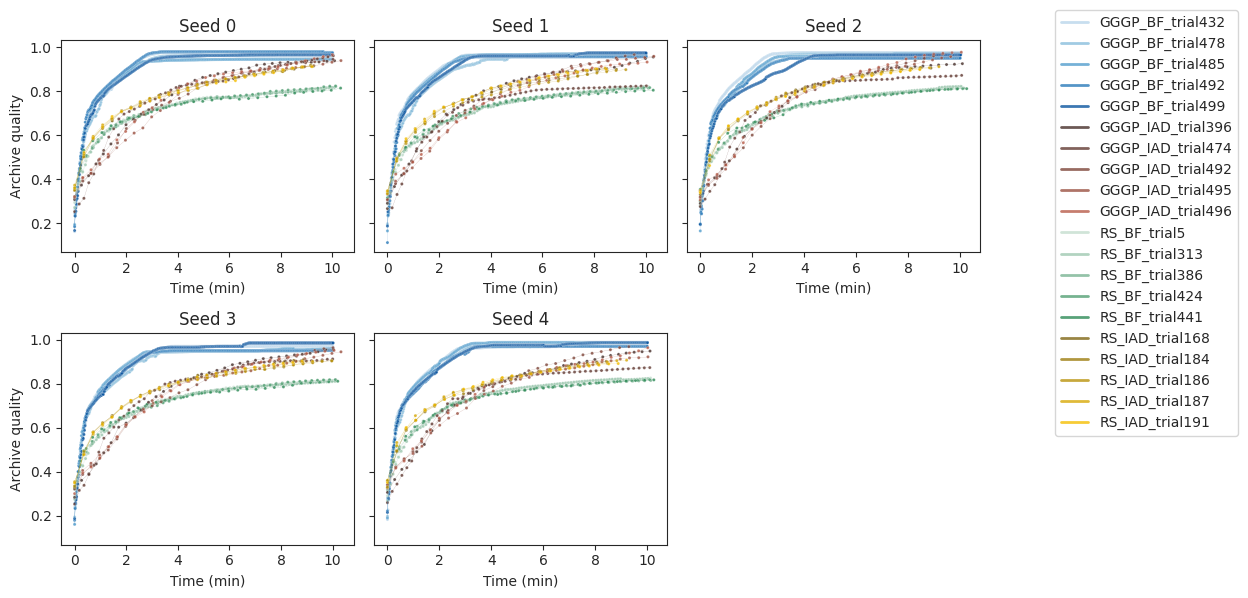

In [19]:
lineplots_through_time(archives, y='Archive_quality', color_pallette=color_pallette)

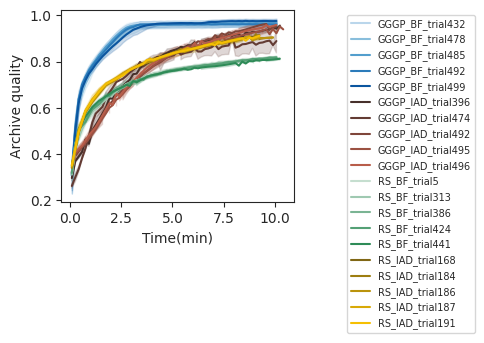

In [20]:
lineplots_through_time(
    archives,
    y="Archive_quality",
    figsize=(3, 2.5),
    time_interval=10,
    per_seed=False,
    color_pallette=color_pallette,
    draw_legend_outside=True,
    outfile='lineplot_through_time.pdf'
)

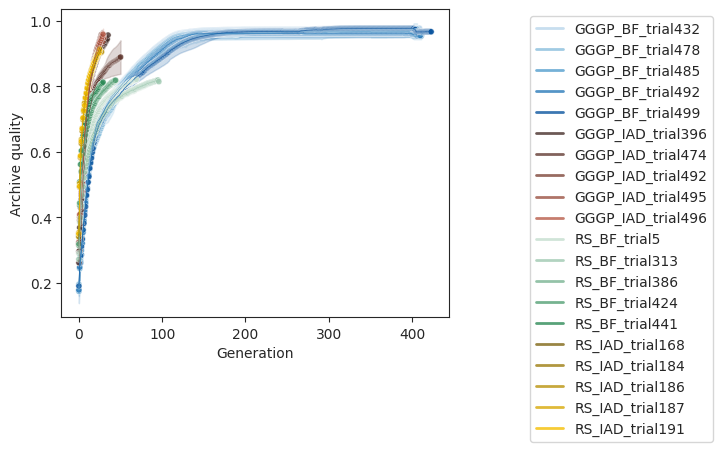

In [21]:
lineplots(archives, y="Archive_quality", color_pallette=color_pallette)

#### Archive diversity

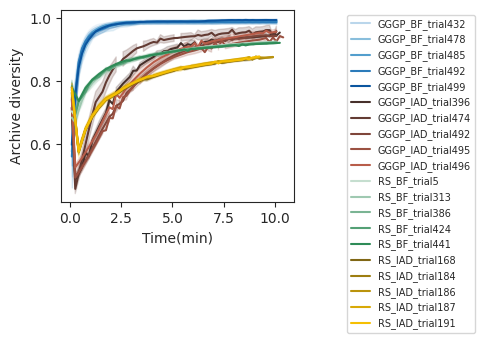

In [22]:
lineplots_through_time(
    archives,
    per_seed=False,
    y="Archive_diversity",
    figsize=(3, 2.5),
    draw_legend_outside=True,
    color_pallette=color_pallette,
)

#### Archive diversity per bin

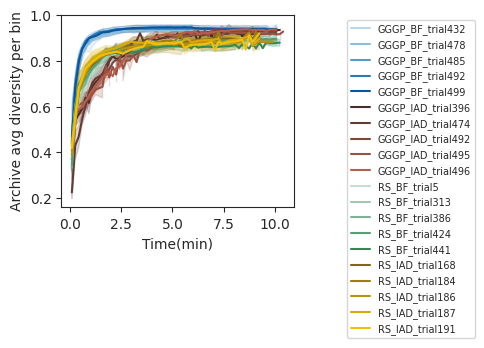

In [23]:
lineplots_through_time(
    archives,
    per_seed=False,
    time_interval=10,
    figsize=(3, 2.5),
    draw_legend_outside=True,
    y="Archive_avg_diversity_per_bin",
    color_pallette=color_pallette,
)

#### Low count bin ratio

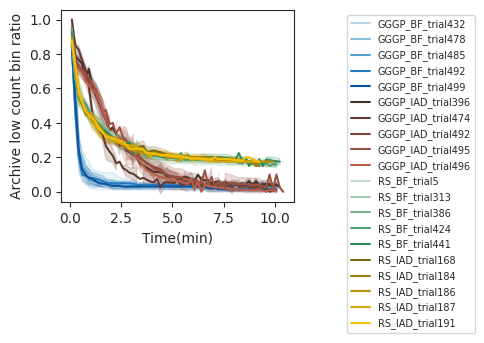

In [24]:
lineplots_through_time(
    archives,
    per_seed=False,
    time_interval=10,
    figsize=(3, 2.5),
    draw_legend_outside=True,
    y="Archive_low_count_bin_ratio",
    color_pallette=color_pallette,
)

#### Avg number of diff units

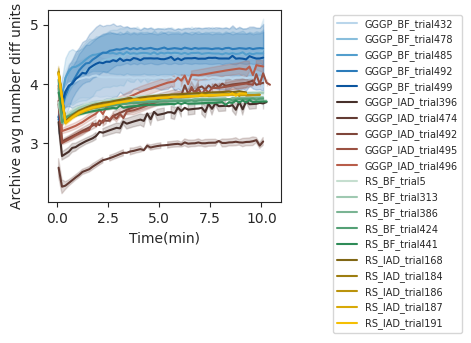

In [25]:
lineplots_through_time(
    archives,
    per_seed=False,
    y="Archive_avg_number_diff_units",
    figsize=(3, 2.5),
    draw_legend_outside=True,
    color_pallette=color_pallette,
)

#### Avg edit distance

In [33]:
subset = archives[archives.Run_id.str.contains("GGGP")].copy()
subset["Run_id"] = pd.Categorical(
    subset.Run_id,
    categories=["GGGP_BF_trial432",  "GGGP_BF_trial478", "GGGP_BF_trial485", "GGGP_BF_trial492", "GGGP_BF_trial499", 
                "GGGP_IAD_trial396", "GGGP_IAD_trial474",  "GGGP_IAD_trial492", "GGGP_IAD_trial495", "GGGP_IAD_trial496"
                ],
    ordered=True,
)

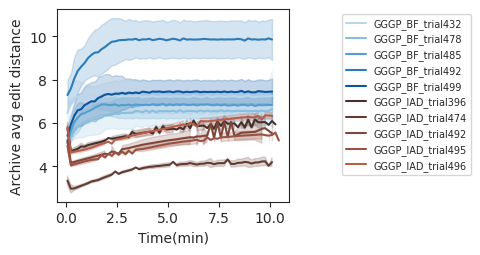

In [35]:
lineplots_through_time(
    subset,
    per_seed=False,
    time_interval=10,
    y="Archive_avg_edit_distance",
    color_pallette=color_pallette[:10],
    figsize=(3, 2.5),
    draw_legend_outside=True,
)

## 2 - Performance comparison

From the best configuration for each strategy, we measured the quality of the final archives.

In [15]:
DATASETS_PATH = '2_performanceComparison/1_bestConfiguration30Seeds/'
evolutions = list(filter(lambda f: os.path.isdir(os.path.join(DATASETS_PATH, f)), os.listdir(DATASETS_PATH)))
evolutions = [os.path.join(DATASETS_PATH, d) for d in evolutions if 'with' not in d]
archives = load_archive_checkpoints(evolutions, seeds=(30, 60), just_last_generation=True)

Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/increase_archive_diversity_3_trial492
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_random_1_trial5
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/increase_archive_diversity_random_4_trial187


In [108]:
archives['Fitness_function'] = archives.Run_id.apply(lambda x: 'BinFiller' if 'bin_filler' in x else 'IAD')
archives['Tag'] = archives.Run_id.apply(lambda x: 'BestRandom' if 'random' in x else 'BestConfig')
archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
archives["Run_id"] = archives.Run_id.replace({'bin_filler_trial499': 'GGGP_BF',
                                              'bin_filler_random_trial5': 'RS_BF',
                                              'IAD_trial492': 'GGGP_IAD',
                                              'IAD_random_trial187': 'RS_IAD'})

archives["Run_id"] = pd.Categorical(
    archives.Run_id,
    categories=["GGGP_BF", "RS_BF", "GGGP_IAD", "RS_IAD"],
    ordered=True,
)

archives["Fitness_function"] = pd.Categorical(
    archives.Fitness_function,
    categories=["BinFiller", "IAD"],
    ordered=True,
)
archives["Tag"] = pd.Categorical(
    archives.Tag,
    categories=["BestConfig", "BestRandom"],
    ordered=True,
)

In [109]:
# Define color palettes
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
green = [sns.light_palette("seagreen")[3]]
gold = [sns.dark_palette("xkcd:golden", 8)[6]]
color_pallette = blue + green + red + gold

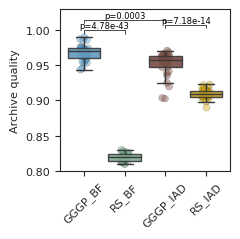

In [110]:
draw_boxplot(
    archives,
    x="Run_id",
    y="Archive_quality",
    ylabel="Archive quality",
    color_pallette=color_pallette,
    do_statistical_test=True,
    figsize=(2.5, 2.5),
    outfile='perf_welch_test.pdf'
)

#### Inspect the fitness functions

The results from Optuna for GGGP with IAD as fitness function displayed a bit of too extreme best parameters.
To test whether Optuna for IAD did not run optimally, we run 30 extra evolutions using the best params found when using BinFiller, but replaced the fitness function to be IAD. Results show that this IAD configuration presents better results than the best one found by optuna

In [62]:
DATASETS_PATH = '2_performanceComparison/1_bestConfiguration30Seeds/'
evolutions = list(filter(lambda f: os.path.isdir(os.path.join(DATASETS_PATH, f)), os.listdir(DATASETS_PATH)))
evolutions = [os.path.join(DATASETS_PATH, d) for d in evolutions if 'random' not in d]
archives = load_archive_checkpoints(evolutions, seeds=(30, 60), just_last_generation=True)

Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/increase_archive_diversity_3_trial492
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/with_IAD_and_best_BF_params


In [63]:
archives['Fitness_function'] = archives.Run_id.apply(lambda x: 'BinFiller' if 'bin_filler' in x else 'IAD')
archives['Tag'] = archives.Run_id.apply(lambda x: 'BestRandom' if 'random' in x else 'BestConfig')
archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
archives["Run_id"] = archives.Run_id.replace({'bin_filler_trial499': 'GGGP_BF',
                                              'IAD_trial492': 'GGGP_IAD',
                                              'with_IAD_and_best_BF_params': 'GGGP_BF_withIAD'})

archives["Run_id"] = pd.Categorical(
    archives.Run_id,
    categories=["GGGP_BF", "GGGP_IAD", "GGGP_BF_withIAD"],
    ordered=True,
)

In [64]:
# Define color palettes
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
gold = [sns.dark_palette("xkcd:golden", 8)[6]]
color_pallette = blue + red + gold

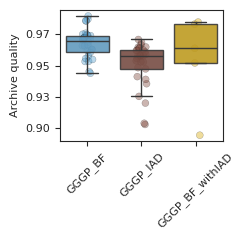

In [65]:
draw_boxplot(
    archives,
    x="Run_id",
    y="Archive_quality",
    ylabel="Archive quality",
    color_pallette=color_pallette,
    do_statistical_test=False,
    figsize=(2.5, 2.5)
)

## 3 - Ablation studies

Study the impact of several components of the GGGP strategy in the final archive quality.

In [24]:
BEST_CONFIG_PATH = os.path.join(os.getcwd(), '2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499/')
LEXICASE_PATH = os.path.join('3_ablationStudies', '1_lexicase')
CUSTOM_MUTATION_PATH = os.path.join('3_ablationStudies', '2_customMutationOperator')
GRAMMAR_NODES_PATH = os.path.join('3_ablationStudies', '3_grammarNodeTypes')

list_dirs = lambda path: [os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
EVOLUTIONS = [[BEST_CONFIG_PATH, LEXICASE_PATH]]

for path in [CUSTOM_MUTATION_PATH, GRAMMAR_NODES_PATH]:
    paths = [BEST_CONFIG_PATH]
    dir_list = list_dirs(path)
    paths = paths + dir_list
    EVOLUTIONS.append([os.path.join(os.getcwd(),  p) for p in sorted(paths)])

### Lexicase selection

In [25]:
LEXICASE_DF = load_archive_checkpoints(
    EVOLUTIONS[0],
    seeds = (30, 60),
    just_last_generation = False,
    tags = ["BestConfig", "Lexicase"],
)

LEXICASE_DF_LAST_GEN = load_archive_checkpoints(
    EVOLUTIONS[0],
    seeds = (30, 60),
    just_last_generation = True,
    tags = ["BestConfig", "Lexicase"],
)

Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499/
Reading directory:  3_ablationStudies/1_lexicase
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499/
Reading directory:  3_ablationStudies/1_lexicase


In [26]:
# Define color palettes
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
color_pallette = blue + red

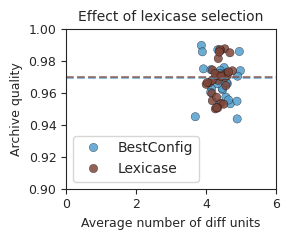

In [27]:
draw_scatterplot(
    LEXICASE_DF_LAST_GEN,
    x="Archive_avg_number_diff_units",
    y="Archive_quality",
    xlabel="Average number of diff units",
    ylabel="Archive quality",
    title="Effect of lexicase selection",
    color_pallette=color_pallette,
    xlim=(0, 6),
    ylim=(0.9, 1), 
    draw_horizontal_line=True
)

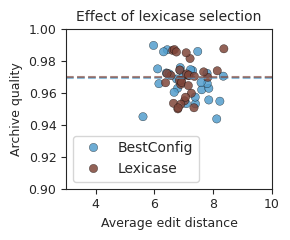

In [28]:
draw_scatterplot(
    LEXICASE_DF_LAST_GEN,
    x="Archive_avg_edit_distance",
    y="Archive_quality",
    xlabel="Average edit distance",
    ylabel="Archive quality",
    title="Effect of lexicase selection",
    color_pallette=color_pallette,
    xlim=(3, 10),
    ylim=(0.9, 1), 
    draw_horizontal_line=True
)

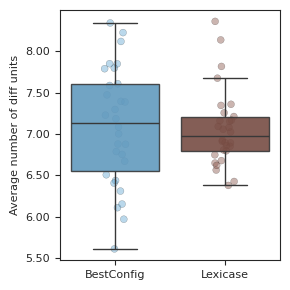

In [32]:
draw_boxplot(
    LEXICASE_DF_LAST_GEN,
    x="Tag",
    y="Archive_avg_edit_distance",
    ylabel="Average number of diff units",
    do_statistical_test=False,
    x_label_rotation=0,
    color_pallette=color_pallette,
)

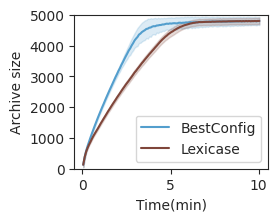

In [33]:
lineplots_through_time(
    LEXICASE_DF,
    y="Archive_size",
    hue="Tag",
    per_seed=False,
    ylabel='Archive size',
    ylim=(0,5000),
    time_interval=5,
    figsize=(2.5, 2),
    color_pallette=color_pallette
)

In [34]:
MELTED = pd.melt(
    LEXICASE_DF,
    id_vars=["Tag", "Time(min)"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

MELTED_LAST_GEN = pd.melt(
    LEXICASE_DF_LAST_GEN,
    id_vars=["Tag"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

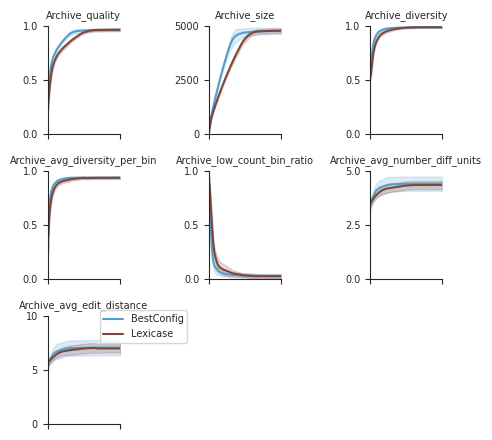

In [35]:
facet_lineplot(
    MELTED, by="Metric", n_cols=3, time_interval=10, color_pallette=color_pallette
)

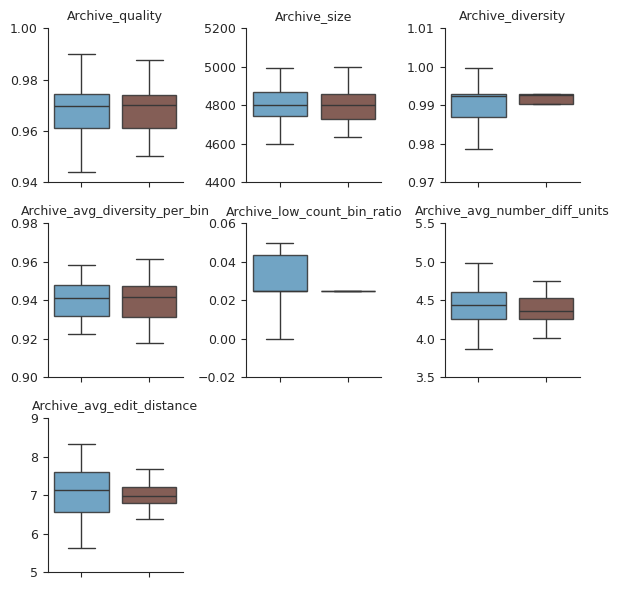

In [36]:
facet_boxplot(MELTED_LAST_GEN, by="Metric", color_pallette=color_pallette)

### Custom mutation operator

In [37]:
CUSTOM_MUTATION_DF_LAST_GEN = load_archive_checkpoints(
    EVOLUTIONS[1],
    seeds = (30, 60),
    just_last_generation = True,
    tags = ["BestConfig", "0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"],
)

CUSTOM_MUTATION_DF_LAST_GEN["Tag"] = pd.Categorical(
    CUSTOM_MUTATION_DF_LAST_GEN.Tag,
    categories=['BestConfig', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', '0.2', '0.1', '0'],
    ordered=True,
)

Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499/
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/2_customMutationOperator/weight_0
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/2_customMutationOperator/weight_0.1
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/2_customMutationOperator/weight_0.2
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/2_customMutationOperator/weight_0.3
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/2_customMutationOperator/weight_0.4
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/2_customMutationOperator/weight_0.5
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/2_customMutationOperator/weight_0.6
Reading directory:  /h

In [38]:
# Define color palettes
blue = [sns.color_palette("Blues")[3]]
red = sns.dark_palette((20, 60, 50), input="husl", n_colors=12)[2:]
color_pallette = blue + red 

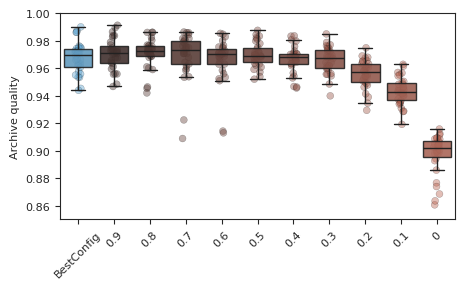

In [39]:
draw_boxplot(
    CUSTOM_MUTATION_DF_LAST_GEN,
    x="Tag",
    y="Archive_quality",
    ylabel="Archive quality",
    figsize=(4.75, 3),
    ylim=(0.85, 1),
    include_xlabels=True,
    x_label_rotation=45,
    color_pallette=color_pallette,
    do_statistical_test=False
)

### Grammar nodes

In [40]:
GRAMMAR_NODES_DF = load_archive_checkpoints(
    EVOLUTIONS[2],
    seeds = (30, 60),
    just_last_generation = False,
    tags = ["BestConfig", "NoDels", "NoDelsAndIns", "NoIns"],
)

GRAMMAR_NODES_DF_LAST_GEN = load_archive_checkpoints(
    EVOLUTIONS[2],
    seeds = (30, 60),
    just_last_generation = True,
    tags = ["BestConfig", "NoDels", "NoDelsAndIns", "NoIns"],
)

GRAMMAR_NODES_DF_LAST_GEN["Tag"] = pd.Categorical(
    GRAMMAR_NODES_DF_LAST_GEN.Tag,
    categories=["BestConfig", "NoDels", "NoIns", "NoDelsAndIns"],
    ordered=True,
)

GRAMMAR_NODES_FULL_DATASETS = load_datasets(EVOLUTIONS[2], ['BestConfig', 'NoDels', 'NoDelsAndIns', 'NoIns'])

Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499/
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/3_grammarNodeTypes/noDeletions
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/3_grammarNodeTypes/noDeletionsAndInsertions
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/3_grammarNodeTypes/noInsertions
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_5_trial499/
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/3_grammarNodeTypes/noDeletions
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/3_grammarNodeTypes/noDeletionsAndInsertions
Reading directory:  /home/pbarbosa/git_repos/genSplicing_analysis/3_ablationStudies/3_grammarNodeTypes/noInsertions
Re

In [41]:
MELTED = pd.melt(
    GRAMMAR_NODES_DF,
    id_vars=["Tag", "Time(min)"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

MELTED_LAST_GEN = pd.melt(
    GRAMMAR_NODES_DF_LAST_GEN,
    id_vars=["Tag"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

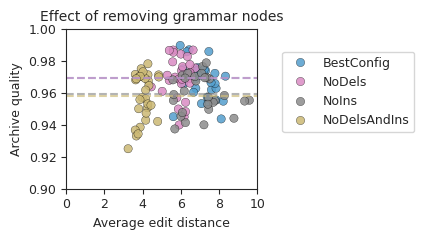

In [42]:
color_pallette = [sns.color_palette("Blues")[3]] + sns.color_palette("deep")[6:9]
draw_scatterplot(
    GRAMMAR_NODES_DF_LAST_GEN, 
    x="Archive_avg_edit_distance", 
    y="Archive_quality",
    xlabel="Average edit distance",
    ylabel="Archive quality",
    title="Effect of removing grammar nodes",
    color_pallette=color_pallette,
    xlim=(0, 10),
    ylim=(0.9, 1.0),
    figsize=(4.5, 2.5),
    legend_outside=True,
    draw_horizontal_line=True
) 

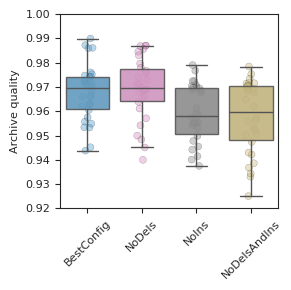

In [43]:
draw_boxplot(
    GRAMMAR_NODES_DF_LAST_GEN,
    x="Tag",
    y="Archive_quality",
    ylabel="Archive quality",
    color_pallette=color_pallette,
    do_statistical_test=False,
    ylim=(0.92, 1.0),
    figsize=(3, 3),
    include_xlabels=True,
    x_label_rotation=45
)

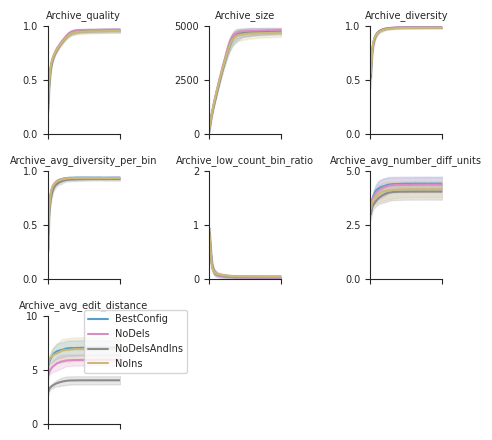

In [44]:
facet_lineplot(MELTED, by="Metric", n_cols=3, time_interval=10, color_pallette=color_pallette)

In [45]:
from datasetgeneration.archive import Archive

tidy_data = []
for group, data in GRAMMAR_NODES_FULL_DATASETS.groupby('Tag'):

    no_dup = data.drop_duplicates(subset=['Sequence', 'Phenotype']).drop_duplicates('Sequence')
    bin_counts = Archive(dataset=no_dup).binarize()
    df = pd.DataFrame.from_dict(bin_counts, orient='index', columns=['Count']).reset_index(names='Bin')
    df['Tag'] = group
    tidy_data.append(df)

tidy_data = pd.concat(tidy_data, ignore_index=True)
tidy_data["Tag"] = pd.Categorical(
    tidy_data.Tag,
    categories=["BestConfig", "NoDels", "NoIns", "NoDelsAndIns"],
    ordered=True,
)

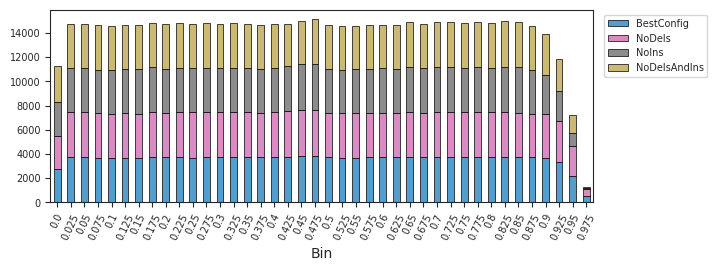

In [46]:
per_bin_filling(tidy_data, color_pallette=color_pallette)

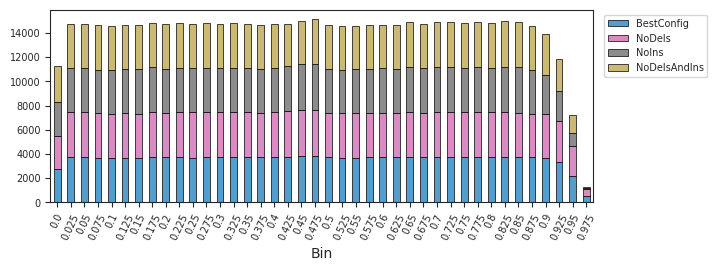

In [47]:
per_bin_filling(tidy_data, color_pallette=color_pallette)

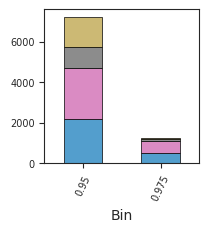

In [48]:
per_bin_filling(
    tidy_data, color_pallette=color_pallette, filter_by=0.94, draw_legend=False, figsize=(2,2)
)

## 4 - Generalization

Evaluate the capacity of the algorithm to generalize to other sequences. The dataset is composed by exons that were seen to be differentially spliced upon knockdown of RBFOX2, an RNA-binding protein that is known to be involved in alternative splicing.

#### Auxiliar information (original dPSI, sequence length, SpliceAI score of original sequence)

In [30]:
# dPSI
dpsi_df = pd.read_csv(
    "4_generalization/RBFOX2_knockdown/preprocessing_dPSI.tsv", sep="\t"
).rename(columns={"header_long": "Seq_id"})

# Original SpliceAI score
original_seqs = glob.glob("4_generalization/RBFOX2_knockdown/*_original_seq.csv")
dfs = []
for fn in original_seqs:
    df = pd.read_csv(fn)
    dfs.append(df)
original_seqs_df = pd.concat(dfs)[['Seq_id', 'Score']]

# Seq lengths
seqs = []
for id, seq in pyfaidx.Fasta(
    "4_generalization/RBFOX2_knockdown/preprocessing_sequences_trimmed_at_5000bp.fa"
).items():
    seqs.append([id, len(seq)])
seqs_df = pd.DataFrame(seqs, columns=["Seq_id", "Seq_len"])

dpsi_df = dpsi_df.merge(seqs_df).merge(original_seqs_df)
dpsi_df.rename(columns={'Score': 'SpliceAI_score'}, inplace=True)

#### Datasets

In [31]:
DATASETS_PATH = {
    "GGGP": "4_generalization/RBFOX2_knockdown",
    #"RS": "4_generalization/RBFOX2_knockdown_randomSearch",
    "RS": "4_generalization/RBFOX2_knockdown_randomSearch_old",
}
archives = load_archive_checkpoints(
    list(DATASETS_PATH.values()),
    tags=list(DATASETS_PATH.keys()),
    seeds=(0, 5),
    just_last_generation=True,
)

Reading directory:  4_generalization/RBFOX2_knockdown
Reading directory:  4_generalization/RBFOX2_knockdown_randomSearch_old


In [32]:
archives = archives.merge(dpsi_df, how="left", on="Seq_id")
avg_across_seed = (
    archives.groupby(["Tag", "Seq_id", "dPSI", "Seq_len", "SpliceAI_score"])
    .agg({"Archive_quality": "mean"})
    .reset_index()
)

In [33]:
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
color_pallette = blue + red

In [34]:
bins = [0, 2000, 4000, 6000, 8000, 10000, 12000]
labels = ["0-2kb", "2kb-4kb", "4kb-6kb", "6kb-8kb", "8kb-10kb", "10kb-12kb"]

avg_across_seed['Seq_len_range'] = pd.cut(avg_across_seed['Seq_len'], bins=bins, labels=labels)

In [39]:
avg_across_seed

,Tag,Seq_id,dPSI,Seq_len,SpliceAI_score,Archive_quality,Seq_len_range
0,GGGP,chr10:119104664-119108264(+)_ENST00000648560,0.359,3601,0.7143,0.80362,2kb-4kb
1,GGGP,chr10:122426842-122432445(+)_ENST00000368989,-0.220,5604,0.7596,0.92220,4kb-6kb
2,GGGP,chr10:26751498-26759338(-)_ENST00000376140,-0.535,7841,0.3914,0.95366,6kb-8kb
3,GGGP,chr10:27060412-27064181(-)_ENST00000376087,-0.698,3770,0.3383,0.95322,2kb-4kb
4,GGGP,chr10:72102234-72107967(-)_ENST00000342444,-0.551,5734,0.1637,0.62572,4kb-6kb
...,...,...,...,...,...,...,...
287,RS,chr8:85112832-85115684(+)_ENST00000360375,-0.226,2853,0.6883,0.91550,2kb-4kb
288,RS,chr8:89757716-89765596(+)_ENST00000220751,-0.481,7881,0.9827,0.48782,6kb-8kb
289,RS,chr9:125910686-125920927(+)_ENST00000373489,0.491,10242,0.9479,0.53518,10kb-12kb
290,RS,chrX:119620335-119629608(-)_ENST00000394610,0.515,9274,0.1809,0.62294,8kb-10kb


In [45]:
avg_across_seed.groupby('Tag')['Archive_quality'].mean()

Tag
GGGP    0.909828
RS      0.683774
Name: Archive_quality, dtype: float64

In [41]:
avg_across_seed.groupby(['Tag', 'Seq_len_range'])['Archive_quality'].median()

Tag   Seq_len_range
GGGP  0-2kb            0.91746
      2kb-4kb          0.94712
      4kb-6kb          0.93428
      6kb-8kb          0.94966
      8kb-10kb         0.96602
      10kb-12kb        0.94323
RS    0-2kb            0.77630
      2kb-4kb          0.80754
      4kb-6kb          0.72288
      6kb-8kb          0.68314
      8kb-10kb         0.68164
      10kb-12kb        0.64123
Name: Archive_quality, dtype: float64

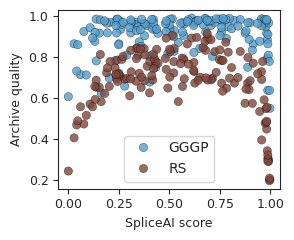

In [35]:
draw_scatterplot(avg_across_seed,
                 x='SpliceAI_score',
                 y='Archive_quality',
                 hue='Tag',
                 xlabel='SpliceAI score',
                 ylabel='Archive quality',
                 alpha=0.8,
                 color_pallette=color_pallette,
                 )

#### Draw a complex heatmap with R 

In [137]:
# Install R within the conda environment
# %conda install -c r r-base -y
# %conda install -c conda-forge rpy2 -y

In [16]:
%load_ext rpy2.ipython

In [139]:
# Install R kernel for Jupyter
# %%R
# install.packages('IRkernel')
# IRkernel::installspec(user = FALSE)

In [140]:
# Install dplyr and ComplexHeatmap package
# %%R
# install.packages("dplyr")
# install.packages("tidyr")
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("ComplexHeatmap")
# library(ComplexHeatmap)
# library(dplyr)

In [23]:
%%R -i archives 
library("ComplexHeatmap")
library("dplyr")
library("tidyr")
library("circlize")

#####################
## Data processing ##
#####################
r_df <- as_tibble(archives) %>% dplyr::select(exon, Tag, Archive_quality, Seq_len, dPSI, SpliceAI_score) %>% dplyr::mutate(exon = as.factor(exon))

mean_per_seed <- r_df %>% 
                group_by(exon, Tag) %>% 
                summarise(Archive_quality = mean(Archive_quality), 
                          Archive_Std = sd(Archive_quality))
                
r_df <- r_df %>% dplyr::select(-Archive_quality) %>% 
                distinct() %>% 
                left_join(mean_per_seed, by=c('exon', 'Tag')) %>% 
                arrange(exon)

# Pivoting
df_wide <- r_df %>%
  pivot_wider(
    id_cols = c(exon, Seq_len, dPSI, SpliceAI_score),
    names_from = Tag, 
    values_from = c(Archive_quality, Archive_Std),
    names_sep = "_"
  )

# Bin by seq len
r_df <- df_wide %>% 
  mutate(Seq_len_range = cut(Seq_len, breaks = c(0, 2000, 4000, 6000, 8000, 10000, 12000), 
                             labels = c("0-2kb", "2kb-4kb", "4kb-6kb", "6kb-8kb", "8kb-10kb", "10kb-12kb"))) %>% 
  arrange(Seq_len)


r_df$Diff <- r_df$Archive_quality_GGGP - r_df$Archive_quality_RS

`summarise()` has grouped output by 'exon'. You can override using the
`.groups` argument.


png 
  2 


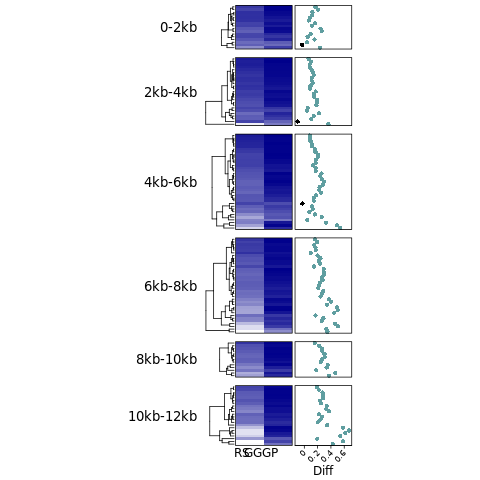

In [113]:
%%R
####################
### Heatmap ###
####################
#r_df <- r_df %>% dplyr::filter(Seq_len_range == "0-2kb")
set.seed(123)

quality_colors <- colorRampPalette(c("white", "darkblue"))(100)
dpsi_colors = colorRamp2(c(0, 1, 30), c("purple", "white", "yellow"))

# Main data
heatmap_matrix <- as.matrix(r_df %>% dplyr::select(c("Archive_quality_RS", "Archive_quality_GGGP")))
row.names(heatmap_matrix) <- r_df$exon
colnames(heatmap_matrix) <- c("RS", "GGGP")

# Row split by seq len
level_order = c("0-2kb", "2kb-4kb", "4kb-6kb", "6kb-8kb", "8kb-10kb", "10kb-12kb")
r_df$Seq_len_range <- factor(r_df$Seq_len_range, 
                             levels = level_order)
row_split <- r_df$Seq_len_range


# HeatmapAnnotation object for dPSI
dpsi_col_fun <- colorRamp2(c(min(r_df$dPSI, na.rm = TRUE), 
                             max(r_df$dPSI, na.rm = TRUE)), 
                           c("blue", "red"))


dpsi_barplot_annotation <- rowAnnotation(
            dPSI = anno_barplot(r_df$dPSI, 
                                col = dpsi_col_fun, 
                                border = FALSE,
                                width = unit(3, "cm"),
                                gp = gpar(lwd = 1, border=TRUE, col = 'black', fill="salmon"),
                                axis_param = list(labels_rot = 45)
    )
        )
# HeatmapAnnotation object for difference in quality
diff_point_annotation <- rowAnnotation(
    `Diff` = anno_points(r_df$Diff, 
                       pch = 16, # solid circle
                       gp = gpar(col = ifelse(r_df$Diff > 0, "cadetblue", "black"), bg=2, size=0.5, lwd = 0.5),
                       width = unit(2, "cm"), 
                       axis_param = list(
                            labels_rot = 45
                        )
    )
)

diff_legend =  Legend(labels = c("<= 0", "> 0"), 
                       legend_gp = gpar(col = c("black", "cadetblue")),
                       title = "Diff (GGGP - RS)",
                       type = "points",
                       pch = 16)


# HeatmapAnnotation object for raw SpliceAI score
spliceai_point_annotation <- rowAnnotation(
    `SpliceAI score` = anno_points(r_df$SpliceAI_score, 
                       pch = 16,
                       gp = gpar(col = "bisque3", bg=2, size=0.5, lwd = 0.5),
                       width = unit(2, "cm"), 
                       axis_param = list(
                            labels_rot = 45
                        )
    )
)

ht_obj <- Heatmap(heatmap_matrix, 
        name = "Archive quality", 
        col = quality_colors,
        show_row_names = FALSE, 
        column_names_rot = 0, 
        column_names_side = "bottom",
        rect_gp = gpar(col = "black", lwd = 1e-10),
        column_names_gp = gpar(fontsize = 12, just = "center"),
        cluster_columns = FALSE,
        column_title = NULL,
        row_split = row_split, 
        cluster_row_slices = FALSE,
        cluster_rows = TRUE, 
        row_title_rot = 0,
        row_gap = unit(3, "mm"),
        border = TRUE,
        width = unit(2, "cm"),
        show_heatmap_legend = FALSE,
        #height = unit(20, "cm"),
        right_annotation = diff_point_annotation
)


ht_drawn <- draw(ht_obj)
default_legend <- color_mapping_legend(ht_drawn@ht_list[[1]]@matrix_color_mapping, plot = FALSE)
ht_combined <- ht_obj + spliceai_point_annotation + dpsi_barplot_annotation

#png("complexheatmap.png", width = 6.5, height = 5.5, units = "in", res = 300)
pdf("complexheatmap.pdf", width = 6.5, height = 5.5)

lgd_list <- list(default_legend, diff_legend)
draw(ht_combined, annotation_legend_list = lgd_list)
dev.off()
